# VQE on Aer simulator with noise for Heisenberg Hamiltonian using Digital gates


In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z, Y

Noisy simulation will be demonstrated here with VQE, finding the minimum (ground state) energy of an Hamiltonian, but the technique applies to any quantum algorithm from Qiskit.

So for VQE we need a qubit operator as input. Here, we will use the Heisenberg Hamiltonian.

In [2]:
def H_heis3(num_qubits):
    # FILL YOUR CODE IN HERE
    H = 0
    #num_qubits = 3
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^X^X^(I^i)
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^Y^Y^(I^i)
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^Z^Z^(I^i)
    # Return Hamiltonian
    return H
H2_op = H_heis3(5)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 5


As the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value so we can compare later the results. 

In [3]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -7.71155


## Performance *without* noise

First we will run on the simulator without adding noise to see the result. I have created the backend and QuantumInstance, which holds the backend as well as various other run time configuration, which are defaulted here, so it easy to compare when we get to the next section where noise is added. There is no attempt to mitigate noise or anything in this notebook so the latter setup and running of VQE is identical.

In [10]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)
counts2 = []
values2 = []
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
counts3 = []
values3 = []
def store_intermediate_result3(eval_count, parameters, mean, std):
    counts3.append(eval_count)
    values3.append(mean)
counts4 = []
values4 = []
def store_intermediate_result4(eval_count, parameters, mean, std):
    counts4.append(eval_count)
    values4.append(mean)
ansatz = TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks='cz',entanglement='linear',reps=2,insert_barriers=True)
ansatz1 =TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks='cz',entanglement='full',reps=2,insert_barriers=True)
ansatz2 = TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks='cz',entanglement='linear',reps=4,insert_barriers=True)
ansatz3 = TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks='cz',entanglement='circular',reps=2,insert_barriers=True)
ansatz4 = TwoLocal(num_qubits=H2_op.num_qubits,rotation_blocks=['rx','rz','ry'],entanglement_blocks='cz',entanglement='linear',reps=2,insert_barriers=True)

In [12]:
print(ansatz.decompose().draw())
print(ansatz1.decompose().draw())
print(ansatz2.decompose().draw())
print(ansatz3.decompose().draw())
print(ansatz4.decompose().draw())

     ┌──────────┐┌──────────┐ ░              ░ ┌───────────┐┌───────────┐ ░    »
q_0: ┤ Rx(θ[0]) ├┤ Rz(θ[5]) ├─░──■───────────░─┤ Rx(θ[10]) ├┤ Rz(θ[15]) ├─░──■─»
     ├──────────┤├──────────┤ ░  │           ░ ├───────────┤├───────────┤ ░  │ »
q_1: ┤ Rx(θ[1]) ├┤ Rz(θ[6]) ├─░──■──■────────░─┤ Rx(θ[11]) ├┤ Rz(θ[16]) ├─░──■─»
     ├──────────┤├──────────┤ ░     │        ░ ├───────────┤├───────────┤ ░    »
q_2: ┤ Rx(θ[2]) ├┤ Rz(θ[7]) ├─░─────■──■─────░─┤ Rx(θ[12]) ├┤ Rz(θ[17]) ├─░────»
     ├──────────┤├──────────┤ ░        │     ░ ├───────────┤├───────────┤ ░    »
q_3: ┤ Rx(θ[3]) ├┤ Rz(θ[8]) ├─░────────■──■──░─┤ Rx(θ[13]) ├┤ Rz(θ[18]) ├─░────»
     ├──────────┤├──────────┤ ░           │  ░ ├───────────┤├───────────┤ ░    »
q_4: ┤ Rx(θ[4]) ├┤ Rz(θ[9]) ├─░───────────■──░─┤ Rx(θ[14]) ├┤ Rz(θ[19]) ├─░────»
     └──────────┘└──────────┘ ░              ░ └───────────┘└───────────┘ ░    »
«               ░ ┌───────────┐┌───────────┐
«q_0: ──────────░─┤ Rx(θ[20]) ├┤ Rz(θ[25]) ├
«               ░ ├

Another option would be to create your own ansatz instead of using on of the predefined ones like TwoLocal. This is especially handy when you want to create an ansatz with analog blocks later.

## A few Observations and Conclusions
- The ansatz which works for a smaller case may not scale well
- The form of entanglement highly affects the capability of finding the true ground state
- Increasing the no. of layers/no. of gates generally but not necessarily mean you'll get a better approximation for the ground state
- The same ansatz works differently for different forms of problem hamiltonians, hence there are problem inspired ansatzes which leverage on the inherent symmetries of the problem and even choose an appropriate initial state, but without any initial knowledge of the hamiltonian, our goal would be to develop hardware efficient and versatile ansatzes
- The Digital Ansatz used in DigitalVQE_Heisenberg.ipynb gives a good approximation of the ground state energy (Better than all in this file)

In [24]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -6.83398
Delta from reference energy value is 0.87756


In [14]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz1, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -4.55078
Delta from reference energy value is 3.16076


In [15]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz2, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -6.51367
Delta from reference energy value is 1.19787


In [16]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz3, optimizer=spsa, callback=store_intermediate_result3, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -5.42773
Delta from reference energy value is 2.28381


In [17]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz4, optimizer=spsa, callback=store_intermediate_result4, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -6.35938
Delta from reference energy value is 1.35217


We captured the energy values above during the convergence so we can see what went on in the graph below.

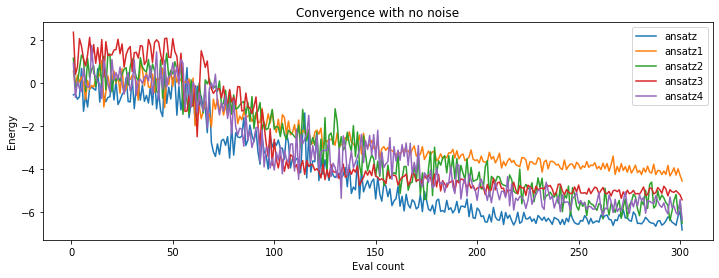

In [18]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values, label='ansatz')
pylab.plot(counts1, values1,label='ansatz1')
pylab.plot(counts2, values2,label='ansatz2')
pylab.plot(counts3, values3,label='ansatz3')
pylab.plot(counts4, values4,label='ansatz4')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')
pylab.legend()

## Performance *with* noise

Now we will add noise. Here we will create a noise model for Aer from an actual device. You can create custom noise models with Aer but that goes beyond the scope of this notebook. Links to further information on Aer noise model, for those that may be interested in doing this, were given above.

First we need to get an actual device backend and from its `configuration` and `properties` we can setup a coupling map and a noise model to match the device. While we could leave the simulator with the default all to all map, this shows how to set the coupling map too. Note: We can also use this coupling map as the entanglement map for the variational form if we choose.

Note: simulation with noise will take longer than without noise.

Terra Mock Backends:

We will use real noise data for an IBM Quantum device using the date stored in Qiskit Terra. Specifically, in this tutorial, the device is ibmq_vigo.

In [19]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
countsa1 = []
valuesa1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_resulta1(eval_count, parameters, mean, std):
    countsa1.append(eval_count)
    valuesa1.append(mean)

#var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_resulta1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'cx', 'measure', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]

VQE on Aer qasm simulator (with noise): 

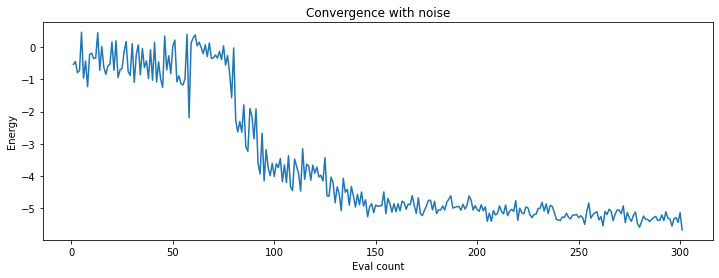

In [21]:
if countsa1 or valuesa1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(countsa1, valuesa1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

## Performance *with* noise and measurement error mitigation

Now we will add method for measurement error mitigation, which increases the fidelity of measurement. Here we choose `CompleteMeasFitter` to mitigate the measurement error. The calibration matrix will be auto-refresh every 30 minute (default value).

Note: simulation with noise will take longer than without noise.

In [22]:
from qiskit.utils.mitigation import CompleteMeasFitter

countsa2 = []
valuesa2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_resulta2(eval_count, parameters, mean, std):
        countsa2.append(eval_count)
        valuesa2.append(mean)

    #ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_resulta2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise and measurement error mitigation): -6.94336
Delta from reference energy value is 0.76819


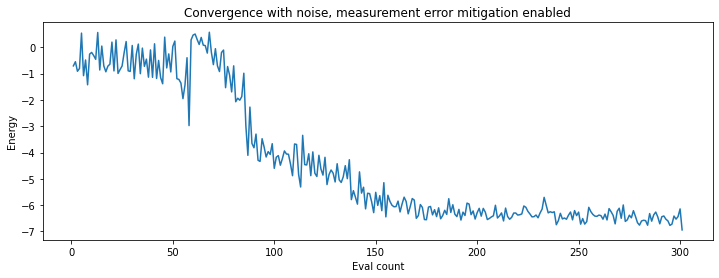

In [23]:
if countsa2 or valuesa2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(countsa2, valuesa2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled')

Lets bring the results together here for a summary. 

We produced a reference value using a classical algorithm and then proceeded to run VQE on a qasm simulator. While the simulation is ideal (no noise) there is so called shot-noise due to sampling - increasing the number of shots reduces this as more and more samples are taken, but shots was left at the default of 1024 and we see a small effect in the outcome. 

Then we added noise using a model taken off a real device and can see the result is affected. Finally we added measurement noise mitigation which adjusts the results in an attempt to alleviate the affect of noise in the classical equipment measuring the qubits.

In [25]:
print(f'Reference value: {ref_value:.5f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')

Reference value: -7.71155
VQE on Aer qasm simulator (no noise): -6.83398
VQE on Aer qasm simulator (with noise): -5.67383
VQE on Aer qasm simulator (with noise and measurement error mitigation): -6.94336
